## Imports

In [1]:
import os
import json
from collections import defaultdict
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from skimage.color import rgba2rgb, rgb2gray
import matplotlib.pyplot as plt

## Globals

In [ ]:
FAST_TESTING = False

DATA_PATH = 'dataset-images'
LOG_PATH = 'logs'
MODEL_PATH = 'models'
HISTORY_PATH = 'history'

def debug_imgs(label='hail', cols=10):
    imgs = data[data['label'] == label]['img']

    rows = len(imgs) // cols + 1

    _, axs = plt.subplots(rows, cols, figsize=(cols * 0.8, rows * 0.8))

    for i, img in enumerate(imgs):
        row = i // cols
        col = i % cols
        axs[row, col].imshow(img)
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

## Load images
At first, we removed the troll images by looking at the outliers per label. But this didn't remove them all and forced us to use a high contamination which made the small dataset even smaller. So we decided to manually remove them with the troll_imgs list. Since we don't have much data to decide outliers anyway and it's not the point of the assignment, we commented it entirely. This changed the training set from 50 to 56 per label (`77 (lowest label count) * 0.9 (test set) * 0.8 (validate set)`).

In [3]:
troll_imgs = [
    284,285,286,287,
    383,384,385,386,387,
    624,625,626,
    676,677,678,679,680,681,682,683]

def load_images(path, indexes_to_exclude=[]):
    global data, label_count

    data = defaultdict(list)

    for i, file_name in enumerate(os.listdir(path)):
        if not file_name.endswith('.png'):
            continue
        if i in indexes_to_exclude:
            continue

        img = load_img(
            os.path.join(DATA_PATH, file_name),
            target_size=(128, 128),
            color_mode='rgba')
        
        # Turn image grayscale with sklearn because it turns transparent pixels white in constrast to keras.
        # Unintentionally also scales it.
        img_array = img_to_array(img)
        img_array = rgb2gray(rgba2rgb(img_array))
        img_array = img_array.reshape((128, 128, 1))
        data['img'].append(img_array)

        label = file_name.split('_')[0]
        data['label'].append(label)

    label_count = len(np.unique(data['label']))

load_images(DATA_PATH, troll_imgs)

## Normalize
Making the images binary seems to make the models worse.

In [4]:
def normalize_data():
    data['img'] = np.array(data['img'])
    # The background is 0.999997 for some reason. Round it.
    data['img'][data['img'] > 0.99] = 1.0
    # Make image binary.
    # data['img'] = data['img'] > 0.99

    data['label_num'] = LabelEncoder().fit_transform(data['label'])
    data['label_one_hot'] = to_categorical(data['label_num'])

normalize_data()

## Get image info
The info used to decide the outliers.

In [5]:
# check_value = 1.0
# if type(data['img'][0][0,0,0]) == np.bool_:
#     check_value = True

# data['black_pixels_top'] = [np.sum(img[:64,:,0] != check_value) for img in data['img']]
# data['black_pixels_bottom'] = [np.sum(img[64:,:,0] != check_value) for img in data['img']]

## Make data a pandas data frame

In [6]:
def data_to_df():
    global data, labels

    data = pd.DataFrame({
        'img': list(data['img']),
        'label': data['label'],
        'label_num': data['label_num'],
        'label_one_hot': list(data['label_one_hot']),
        # 'black_pixels_top': data['black_pixels_top'],
        # 'black_pixels_bottom': data['black_pixels_bottom']
    })

    labels = data.drop_duplicates(subset='label_num').sort_values(by='label_num')['label'].tolist()

data_to_df()

## Remove outliers

In [7]:
# print(len(data))

# columns_to_check = ['black_pixels_top', 'black_pixels_bottom']
# def remove_outliers(group):
#     isolation_forest = ensemble.IsolationForest(contamination=0.005)
#     outliers = isolation_forest.fit_predict(group[columns_to_check])
#     return group[outliers != -1]

# data = data.groupby('label_num', group_keys=False)[data.columns.tolist()].apply(remove_outliers)
# data.reset_index(drop=True, inplace=True)

# print(len(data))

## Split data into sets

In [8]:
# Use the same amount of images for each label (balancing)
smallest_label_data_count = data['label_num'].value_counts().min()
data = data.groupby('label_num')[data.columns.tolist()].apply(lambda x: x.sample(smallest_label_data_count, random_state=0))
data.reset_index(drop=True, inplace=True)

X = np.stack(data['img'])
y = np.stack(data['label_one_hot'])

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=0)
X_train, X_validate, y_train, y_validate = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=0)

for i in range(len(y_train[0])):
    print(len(y_train[y_train[:,i] == 1]))

55
56
56
55
55
55
56
55
56
55
55


Some models will use this data generator to compensate for the small training set. The values are quite small as I noticed moderate modifications quickly make the models nearly useless.

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest')

datagen.fit(X_train, seed=0)

## Test functions
These will be used to show training progress and test performance.

As a heads up: for models trained with the ImageDataGenerator, the testing accuracy may be quite a bit higher than the training accuracy as during training the images are transformed. This makes the model more general and helps with overfitting but also makes it harder for the model to get high accuracy during training.

In [10]:
def draw_acc_and_loss_graphs(history):
    plt.figure(figsize=(9, 2))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.show()

In [11]:
def test(model, history, testing_X=X_test, testing_y=y_test, imgs_per_label=4):
    draw_acc_and_loss_graphs(history)

    print(f"Training Accuracy: {history['accuracy'][-1]:.4f} | Loss: {history['loss'][-1]:.4f}")
    print(f"Validation Accuracy: {history['val_accuracy'][-1]:.4f} | Loss: {history['val_loss'][-1]:.4f}")

    if not FAST_TESTING:
        test_loss, test_accuracy = model.evaluate(testing_X, testing_y, verbose=0)
        print(f"Test Accuracy: {test_accuracy:.4f} | Loss: {test_loss:.4f}")
        
        predictions = model.predict(testing_X, verbose=0)

        _, axs = plt.subplots(imgs_per_label, label_count, figsize=(label_count, imgs_per_label * 1.2))

        img_counts = {label: 0 for label in range(label_count)}
        for i in range(len(predictions)):
            right_label_num = np.argmax(testing_y[i])
            if img_counts[right_label_num] >= imgs_per_label:
                continue

            ax = axs[img_counts[right_label_num], right_label_num]
            ax.set_xticks([])
            ax.set_yticks([])

            ax.imshow(testing_X[i].reshape(128, 128), cmap='gray')

            predicted_label_num = np.argmax(predictions[i])
            color = 'black' if predicted_label_num == right_label_num else 'red'
            ax.set_xlabel(f"{labels[predicted_label_num]}", color=color)

            img_counts[right_label_num] += 1

        plt.show()

## Train
In this section, the models will be trained, saved and tested. If a save already exists, training is skipped and the save is used for testing instead.
This is to speed things up during development and so that others can run the full notebook without long waiting times.

Here you can also find my notes on reasoning and discoveries.

#### Helper functions
The model variations use these variables and functions for easier global changes and less duplicate code.

In [ ]:
# By commenting some of these I can easily skip model executions. For testing and if one is temporarily broken.
models_to_run = [
    # 1,
    # 2,
    # 3,
    # 4,
    # 5,
    # 6,
    # 7,
    # 8,
]

loss = 'categorical_crossentropy'
metrics = ['accuracy']
validation_data=(X_validate, y_validate)

def load_existing_model(model_num):
    model_path = f'{MODEL_PATH}{os.sep}{model_num}.keras'
    history_path = f'{HISTORY_PATH}{os.sep}{model_num}.json'
    if not os.path.exists(model_path) or not os.path.exists(history_path):
        return None, None
    
    model = tf.keras.models.load_model(model_path)
    with open(history_path, 'r') as f:
        history = json.load(f)
    
    return model, history

def create_model(layer_array):
    layer_array.insert(0, layers.Input(shape=(128, 128, 1)))
    layer_array.append(layers.Dense(label_count, activation='softmax'))
    return models.Sequential(layer_array)

def create_callbacks(model_num):
    # To save logs during training so progress can be viewed in TensorBoard.
    # Commented for now because it makes A LOT of logs and it's not needed unless I want to debug an issue.
    # return [TensorBoard(log_dir=f'{LOG_PATH}{os.sep}{model_num}', histogram_freq=1)]
    return []

def save_model(model, model_num, training_data):
    os.makedirs(MODEL_PATH, exist_ok=True)
    model.save(f'{MODEL_PATH}{os.sep}{model_num}.keras')

    history = {}
    history["accuracy"] = training_data.history["accuracy"]
    history["val_accuracy"] = training_data.history["val_accuracy"]
    history["loss"] = training_data.history["loss"]
    history["val_loss"] = training_data.history["val_loss"]

    os.makedirs(HISTORY_PATH, exist_ok=True)
    with open(f'{HISTORY_PATH}{os.sep}{model_num}.json', 'w') as f:
        json.dump(history, f)
    
    return history

#### Model 1
Just a simple CNN with 2 conv layers increasing in size and 2 dense layers (excluding output) decreasing. No fix for overfitting yet.

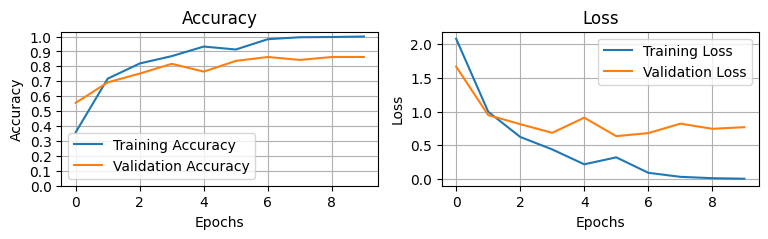

Training Accuracy: 1.0000 | Loss: 0.0060
Validation Accuracy: 0.8627 | Loss: 0.7698
Test Accuracy: 0.8706 | Loss: 0.4831


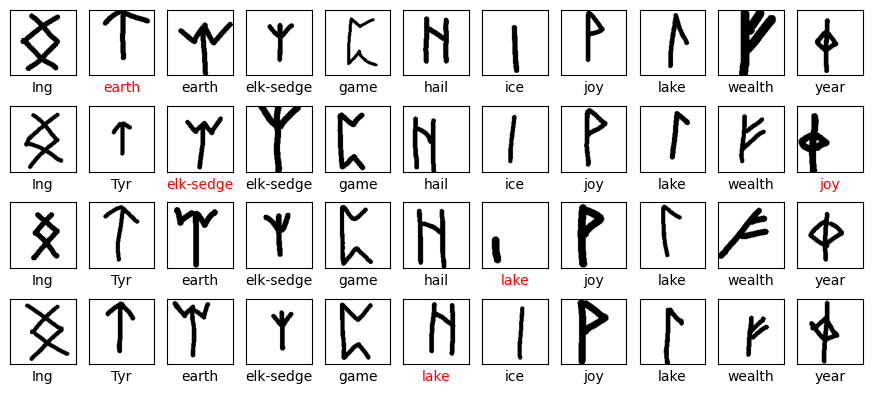

In [13]:
model_num = 1
if model_num in models_to_run:
    model, history = load_existing_model(model_num)
    if not model:
        model = create_model([
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu')
        ])

        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=metrics)

        training_data = model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=10,
            validation_data=validation_data,
            callbacks=create_callbacks(model_num))

        history = save_model(model, model_num, training_data)
    
    test(model, history)

As expected, train accuracy is `1.0` as there is nothing stopping it from overfitting. Test accuracy is already surprisingly high at `0.85` to `0.92` between fits.

#### Model 2
Same as model 1 but with 25 epochs. Lets see if this shows more overfitting signs.

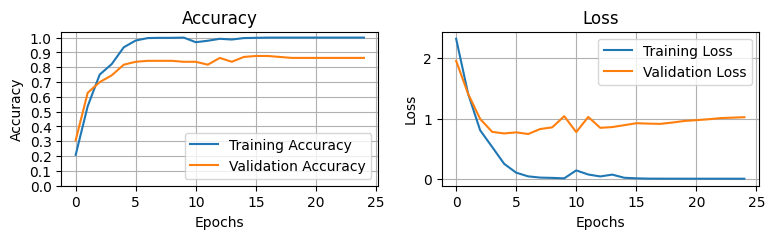

Training Accuracy: 1.0000 | Loss: 0.0004
Validation Accuracy: 0.8627 | Loss: 1.0223
Test Accuracy: 0.9059 | Loss: 0.4793


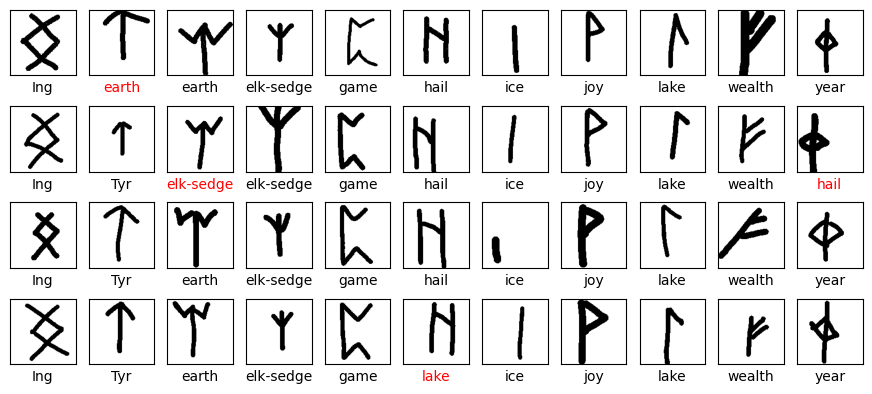

In [14]:
model_num = 2
if model_num in models_to_run:
    model, history = load_existing_model(model_num)
    if not model:
        model = create_model([
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu')
        ])

        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=metrics)

        training_data = model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=25,
            validation_data=validation_data,
            callbacks=create_callbacks(model_num))

        history = save_model(model, model_num, training_data)
    
    test(model, history)

Validation loss goes up a bit over time but the test accuracy doesn't seem to become much worse.

#### Model 3
Same as model 1 except it has a dropout between the dense layers. Overfitting doesn't seem to be a problem with this low layer count/size but lets see if it makes things better anyway.

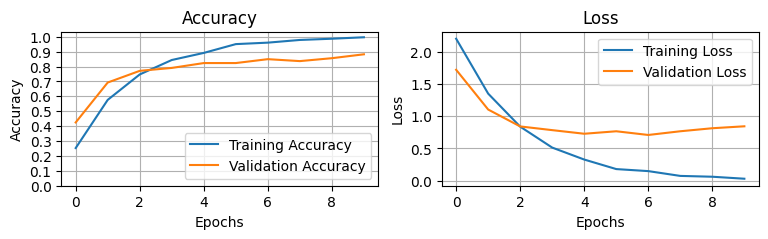

Training Accuracy: 0.9967 | Loss: 0.0298
Validation Accuracy: 0.8824 | Loss: 0.8453
Test Accuracy: 0.9059 | Loss: 0.4524


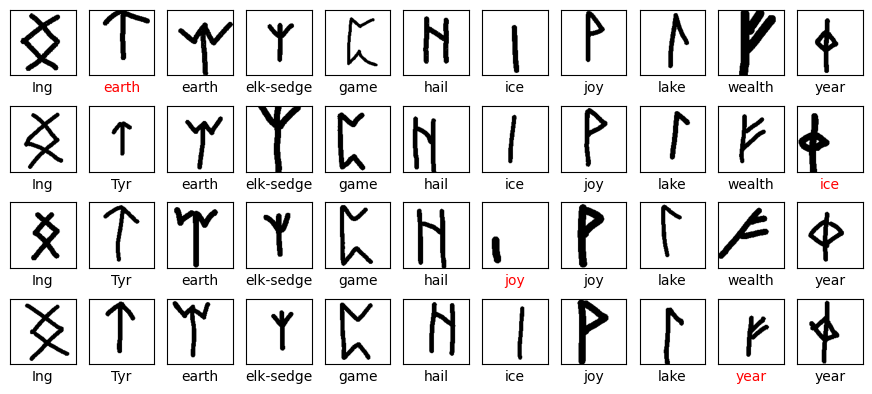

In [15]:
model_num = 3
if model_num in models_to_run:
    model, history = load_existing_model(model_num)
    if not model:
        model = create_model([
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(64, activation='relu')
        ])

        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=metrics)

        training_data = model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=10,
            validation_data=validation_data,
            callbacks=create_callbacks(model_num))

        history = save_model(model, model_num, training_data)
    
    test(model, history)

As expected, train accuracy is often a bit lower but test a bit higher.

#### Model 4
Same as model 3 but it uses swish for all activations. I heard it's a new method that is slightly better.

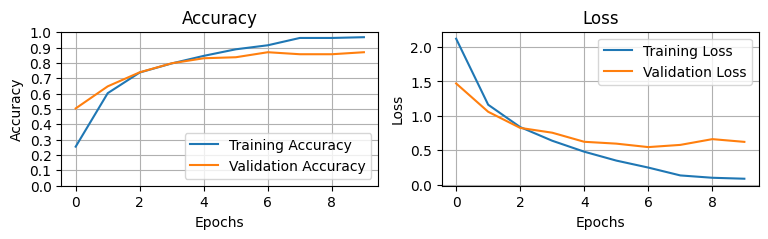

Training Accuracy: 0.9672 | Loss: 0.0888
Validation Accuracy: 0.8693 | Loss: 0.6235
Test Accuracy: 0.8706 | Loss: 0.5073


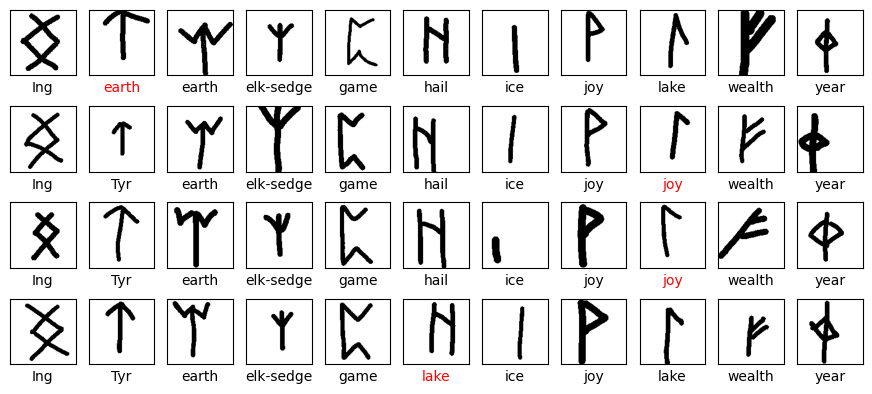

In [16]:
model_num = 4
if model_num in models_to_run:
    model, history = load_existing_model(model_num)
    if not model:
        model = create_model([
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='swish'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='swish'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='swish'),
            layers.Dropout(0.2),
            layers.Dense(64, activation='swish')
        ])

        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=metrics)

        training_data = model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=10,
            validation_data=validation_data,
            callbacks=create_callbacks(model_num))

        history = save_model(model, model_num, training_data)
    
    test(model, history)

Earlier I had the learning rate of all models at 0.01, there the relu ones were a bit worse but still usable. Swish however had the interesting behavior of going up until around epoch 4 and then going and staying down:

<img style="width:600px;" src="assets/model 4 low lr.png"><br>

But with lr at 0.001 it indeed gives higher test accuracy on average.

#### Model 5
We did some deep diving into ways to improve the model further and decided to wing it and try many things at once.

- More layers
- Spatial dropout for convolutional layer overfitting
- Global average pooling instead of flattening which gives a single value per feature for more generalization but less spatial info
- A kernal regularizer instead of dropout which prevents overfitting differently by keeping weights relatively low with penalizing
- A callback to reduce lr at the right moments
- A callback to stop training early when it sees no noticable changes in loss for multiple cycles
- Data through the data transformer for more generalization.

In our defense, one of us already has experience with NNs and the other learned a lot througn assignment 1, so the previous iterations were admittedly boring and not very educational.

Since it's a deeper network, a lot more epochs are needed before improvement slows down.

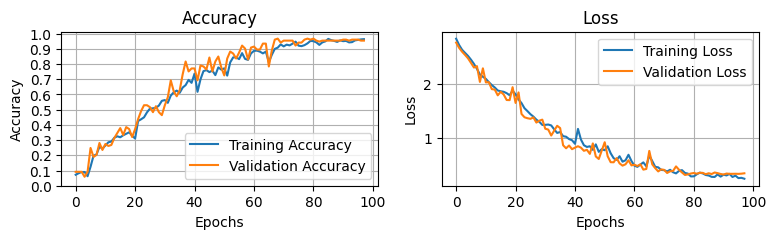

Training Accuracy: 0.9639 | Loss: 0.2416
Validation Accuracy: 0.9542 | Loss: 0.3427
Test Accuracy: 0.9647 | Loss: 0.2058


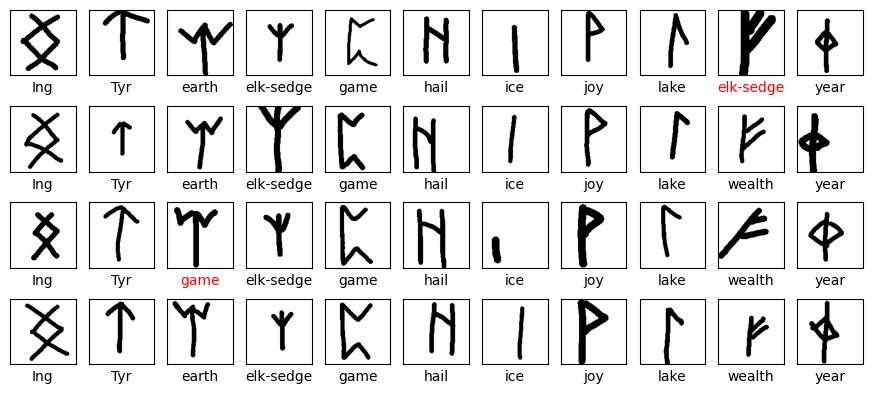

In [17]:
model_num = 5
if model_num in models_to_run:
    model, history = load_existing_model(model_num)
    if not model:
        kernel_regularizer = tf.keras.regularizers.l2(0.001)
        model = create_model([
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.SpatialDropout2D(0.2),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.SpatialDropout2D(0.2),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.SpatialDropout2D(0.2),
            layers.GlobalAveragePooling2D(),

            layers.Dense(256, activation='relu', kernel_regularizer=kernel_regularizer),

            layers.Dense(128, activation='relu', kernel_regularizer=kernel_regularizer),

            layers.Dense(64, activation='relu', kernel_regularizer=kernel_regularizer),
        ])

        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=metrics)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

        training_data = model.fit(
            datagen.flow(X_train, y_train, batch_size=32),
            epochs=150,
            validation_data=validation_data,
            callbacks=create_callbacks(model_num) + [reduce_lr, early_stopping])

        history = save_model(model, model_num, training_data)
    
    test(model, history)

Even with ReduceLROnPlateau making lr dynamic, making the starting value higher (0.01) gave negative results. Depending on the hyperparameters, it either takes too long to changes or sets biases in stone too quickly. 0.001 seems to work well.

The test accuracy is astonishingly high at `0.965`. Using a deeper network clearly increases the maximal complexity and with that the the highest potential accuracy. The trade off is of course training time. It took many minutes and most of the time over 100 epoches for the EarlyStopping to kick in.

We think we skipped a lot of hurdles a larger network brings like long term overfitting and slow convergence by implementing more advanced features right away, so we made model 7 as a bonus.

#### Model 6
This model has a few differences:
- **Conv layer batch normalization:** Normalizes the layers activation based on the current batch. Yet another thing for overfitting, it also allows for higher lr and deeper networks.
- **Lr scheduler instead of callback:** We use an exponential decay scheduler to decrease the lr more systematically over time.

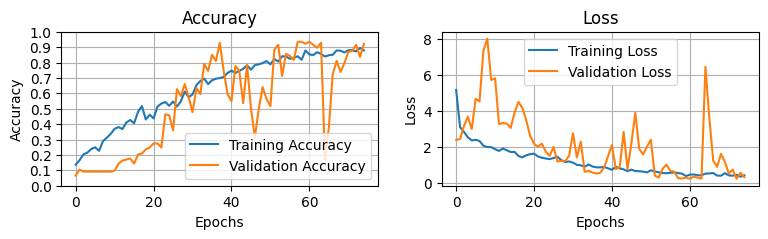

Training Accuracy: 0.8785 | Loss: 0.4344
Validation Accuracy: 0.9216 | Loss: 0.3329
Test Accuracy: 0.9529 | Loss: 0.1370


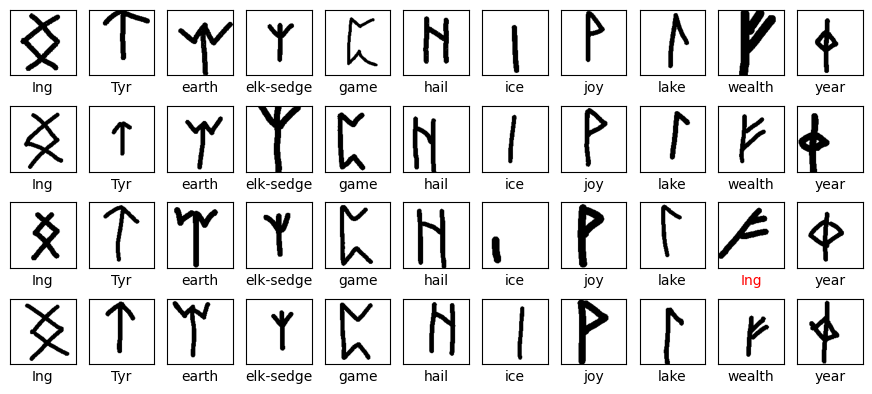

In [18]:
model_num = 6
if model_num in models_to_run:
    model, history = load_existing_model(model_num)
    if not model:
        model = create_model([
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.SpatialDropout2D(0.2),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.SpatialDropout2D(0.2),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.SpatialDropout2D(0.2),
            layers.MaxPooling2D((2, 2)),

            layers.Flatten(),

            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),

            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),

            layers.Dense(64, activation='relu'),
        ])

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            0.003,
            decay_steps=10000,
            decay_rate=0.9,
            staircase=True)

        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),
            loss=loss,
            metrics=metrics)
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

        training_data = model.fit(
            datagen.flow(X_train, y_train, batch_size=32),
            epochs=75,
            validation_data=validation_data,
            callbacks=create_callbacks(model_num) + [early_stopping])

        history = save_model(model, model_num, training_data)
    
    test(model, history)

The validation accuracy is very inconsistent during training. As model 5 doesn't have this problem, we looked at the differences.<br>
Model 5<br>
<img style="width:600px;" src="assets/model 5.png"><br>
Model 6<br>
<img style="width:600px;" src="assets/model 6.png"><br>
We assumed it's either the use of Flatten instead of GlobalAveragePooling2D or not having a kernel regularizer, so we tested it.<br>
The GlobalAveragePooling2D didn't do much. It's a little bit better at the end but worse at the start. Still a weird graph:<br>
<img style="width:600px;" src="assets/model 6 with GlobalAveragePooling2D.png"><br>
But using the same regularizer as model 5 worked a lot better:<br>
<img style="width:600px;" src="assets/model 6 with kernel regularizer.png">

So that model 6 doesn't practically turn into model 5, we kept the code on the initial setup.

#### Model 7
The techniques of model 1 with the depth and epochs of model 5.

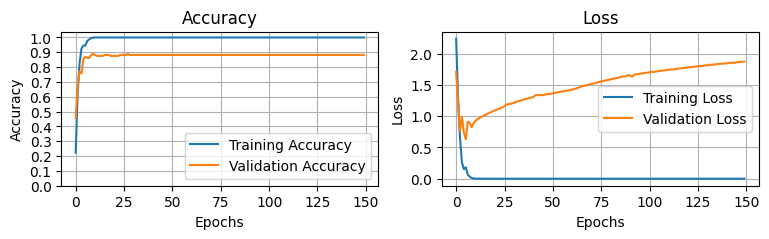

Training Accuracy: 1.0000 | Loss: 0.0000
Validation Accuracy: 0.8824 | Loss: 1.8732
Test Accuracy: 0.8941 | Loss: 1.4238


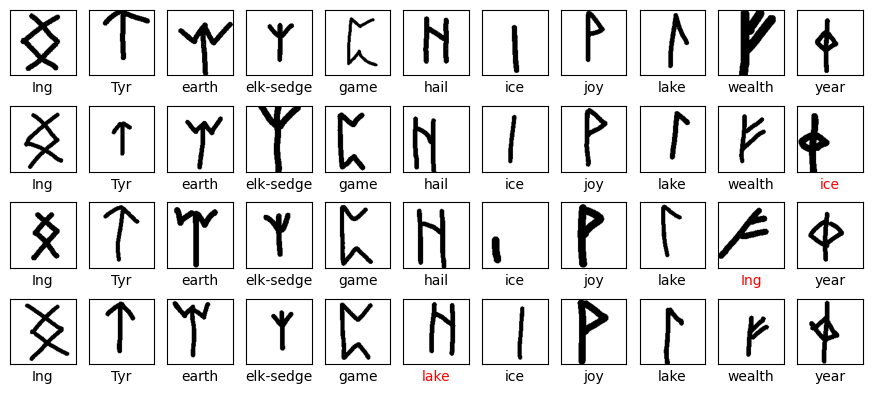

In [19]:
model_num = 7
if model_num in models_to_run:
    model, history = load_existing_model(model_num)
    if not model:
        model = create_model([
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu')
        ])

        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=metrics)

        training_data = model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=150,
            validation_data=validation_data,
            callbacks=create_callbacks(model_num))

        history = save_model(model, model_num, training_data)
    
    test(model, history)

As expected it overfits early on. Surprisingly though it still has a higher test accuracy than the smaller models. We assume this is the result of convolutional layers being quite generalized in nature and maybe the usage of validation. The model doesn't seem to be specifically bad at a certain hieroglyph either. It's just worse at edge cases that weren't in the training set.

As the loss keeps growing, it doesn't stop until 150 epoches are reached. It surpasses a whopping 1.5 validation loss! This just means it's not confident in images it hasn't seen before.

#### Model 8
I'm still curious how the size of the convolution window effects things. 3 by 3 tends to be a good guess ([How to optimize Convolutional Layer with Convolution Kernel](https://data-ai.theodo.com/blog-technique/2019-10-31-convolutional-layer-convolution-kernel)) but how much does it really matter?

Model 3 was used as the base.

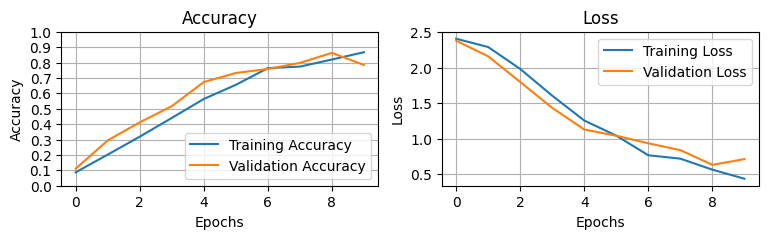

Training Accuracy: 0.8670 | Loss: 0.4362
Validation Accuracy: 0.7843 | Loss: 0.7124
Test Accuracy: 0.8235 | Loss: 0.5048


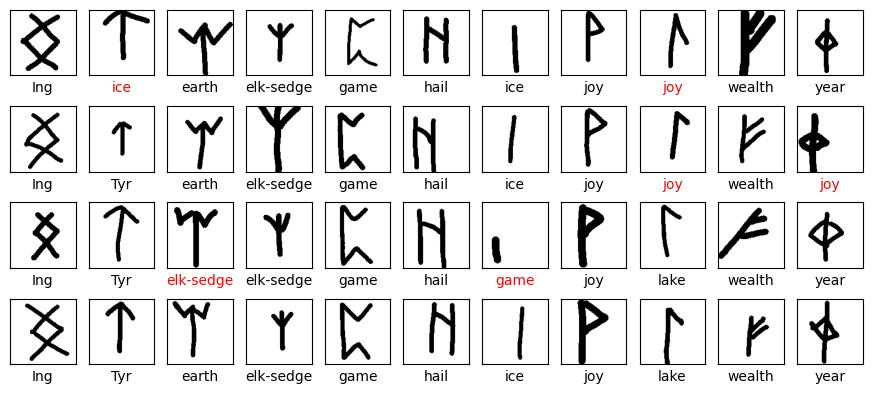

In [20]:
model_num = 8
if model_num in models_to_run:
    model, history = load_existing_model(model_num)
    if not model:
        model = create_model([
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (17, 17), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (17, 17), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(64, activation='relu')
        ])

        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=metrics)

        training_data = model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=10,
            validation_data=validation_data,
            callbacks=create_callbacks(model_num))

        history = save_model(model, model_num, training_data)
    
    test(model, history)

I had the feeling 5x5 wouldn't be much different and I was right:

<img style="width:600px;" src="assets/model 8 5x5.png">

But even 9x9 is only a drop in `~0.02` test accuracy:

<img style="width:600px;" src="assets/model 8 9x9.png">

First at 17x17 (the current version) does it lose enough scope to go down to between `0.80` and `0.85`. A thing to note is that even if 5x5 or 7x7 would be a bit better, the computational cost also increases rapidly.

## Conclusion
Model 5 is the best at guessing never seen before images. There are most likely slight variations from it that will do even better, but since it's a big network, training takes too long to experiment a lot.

=== model 5 ===


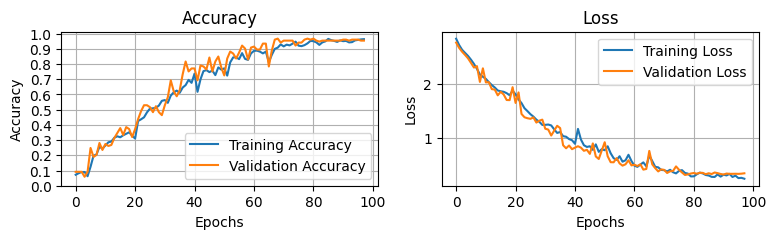

Training Accuracy: 0.9639 | Loss: 0.2416
Validation Accuracy: 0.9542 | Loss: 0.3427
Test Accuracy: 0.9556 | Loss: 0.3529


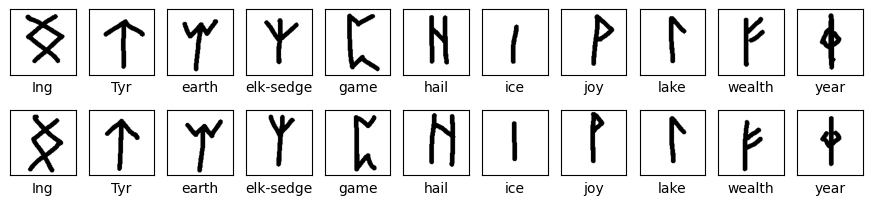

In [ ]:
# remote_data_path = "D:/Coding/Repos/MLBDDeJongMarkvoort/assignment-2/2-2/data"
remote_data_path = input('Please insert the path to the images:')

load_images(remote_data_path)
normalize_data()
data_to_df()

testing_X = np.stack(data['img'])
testing_y = np.stack(data['label_one_hot'])

model, history = load_existing_model(5)
print(f"=== model 5 ===")
test(model, history, testing_X, testing_y, 2)